In [1]:
# imports 

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from env import username, host, password

# functions
from acquire_wrangle import plot_eval, temp_time, get_temp_data


# analysis transformations and techniques

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing


from datetime import timedelta, datetime
from sklearn.metrics import mean_squared_error
from math import sqrt 

# turn off warnings
import warnings
warnings.filterwarnings("ignore")

## Acquisition & Exploration

In [2]:
# acquire data

temp = get_temp_data()

In [3]:
# look at data

temp.sample(3)

dt  AverageTemperature  AverageTemperatureUncertainty  \
45913   1920-01-01               9.146                          0.691   
230058  1774-07-01              20.511                          3.130   
154312  1940-02-01             -11.339                          0.448   

              City  Country Latitude Longitude  
45913   Casablanca  Morocco   32.95N     6.70W  
230058     Toronto   Canada   44.20N    80.50W  
154312    Montreal   Canada   45.81N    72.69W

**The target is being defined as average temperature.**

In [4]:
# shape of imported data

temp.shape

(239177, 7)

In [5]:
# looking at data

temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239177 entries, 0 to 239176
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             239177 non-null  object 
 1   AverageTemperature             228175 non-null  float64
 2   AverageTemperatureUncertainty  228175 non-null  float64
 3   City                           239177 non-null  object 
 4   Country                        239177 non-null  object 
 5   Latitude                       239177 non-null  object 
 6   Longitude                      239177 non-null  object 
dtypes: float64(2), object(5)
memory usage: 12.8+ MB


In [6]:
# checking nulls

temp.isna().sum() / len(temp)

dt                               0.000000
AverageTemperature               0.045999
AverageTemperatureUncertainty    0.045999
City                             0.000000
Country                          0.000000
Latitude                         0.000000
Longitude                        0.000000
dtype: float64

**We can see that 4.6pc of the rows have no data for 'AverageTemperature' and 'AverageTemperatureUncertainty'. This is deemed an insignificant amount, and the rows will be dropped.**

In [7]:
# changing col names, setting index to datetime, dropping nulls

temp = temp_time(temp)

In [8]:
# verifying that they dropped

temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 228175 entries, 1849-01-01 to 2013-08-01
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   avg_temp    228175 non-null  float64
 1   avg_temp_q  228175 non-null  float64
 2   city        228175 non-null  object 
 3   country     228175 non-null  object 
 4   month       228175 non-null  object 
 5   year        228175 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 12.2+ MB


In [9]:
# sample of data 

temp.sample(3)

avg_temp  avg_temp_q    city   country     month  year
date                                                              
1987-12-01    23.311       0.195  Harare  Zimbabwe  December  1987
1870-03-01     6.392       1.082  Madrid     Spain     March  1870
2006-04-01     9.234       0.158  Berlin   Germany     April  2006

Text(0.5, 1.0, 'Average Annual & Monthly Temperatures Around The World, 1750 Through 2013')

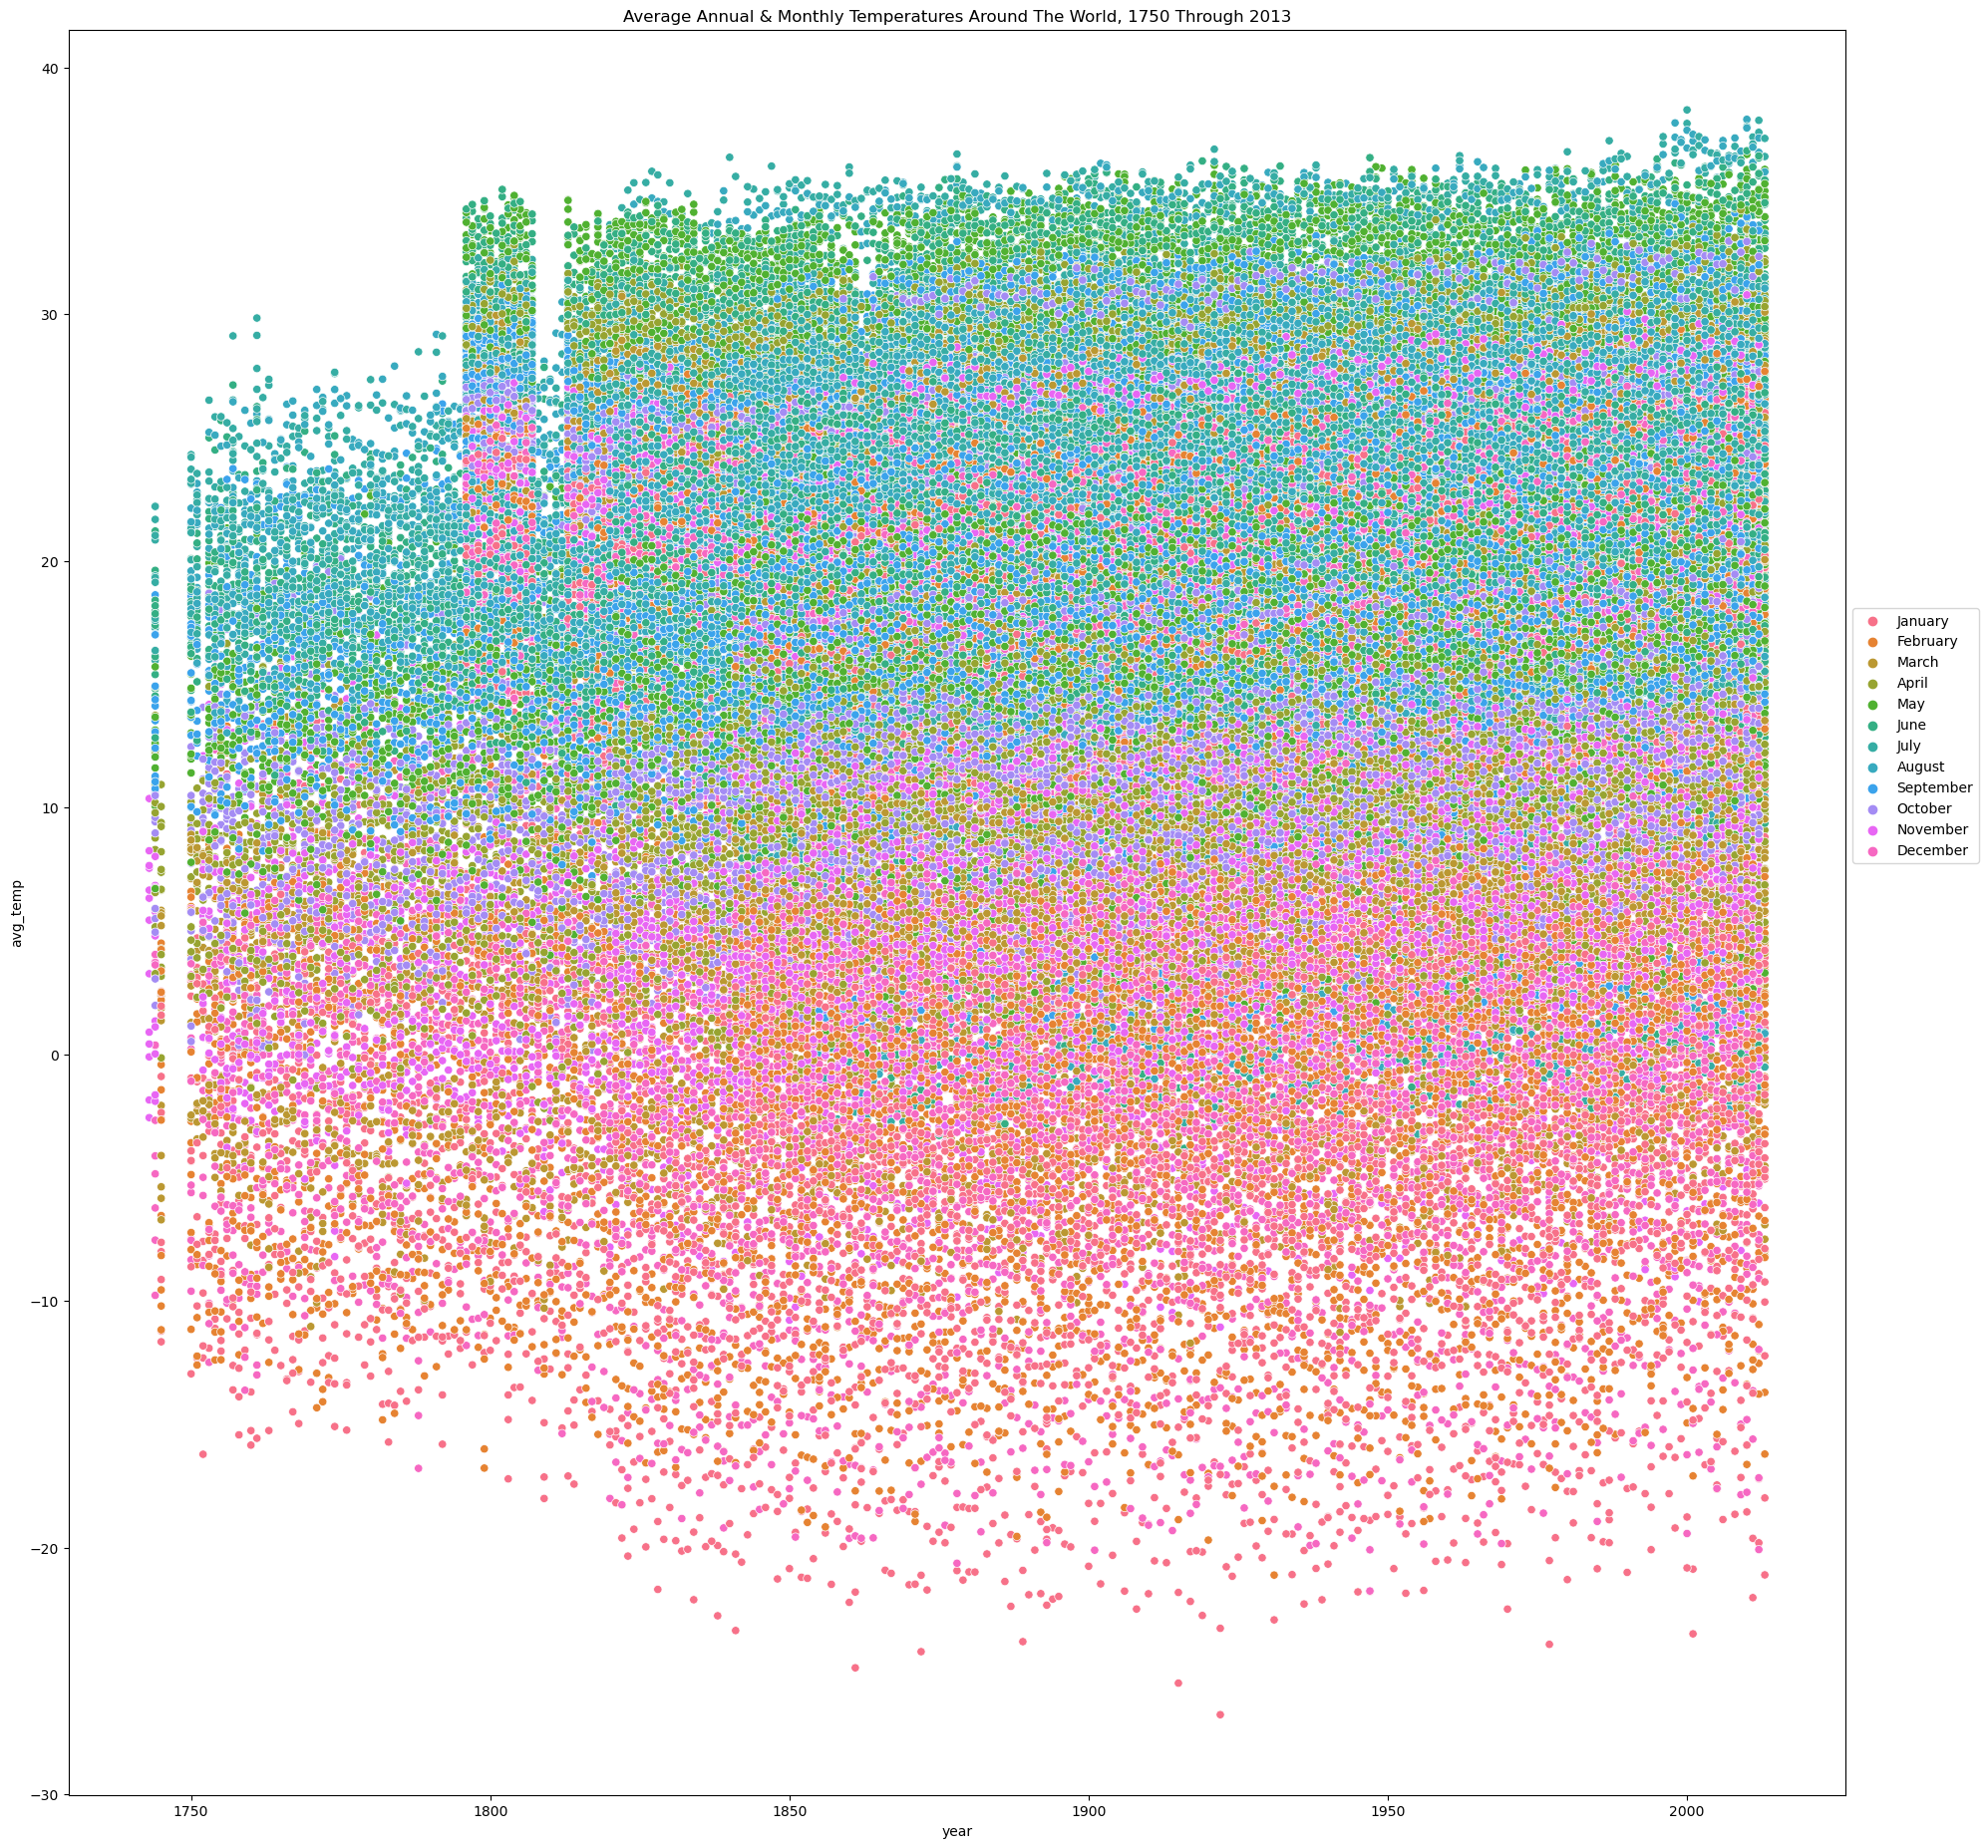

In [10]:
# plotting Average Annual & Monthly Temperatures Around The World, 1750 To Present

plt.figure(figsize = (23, 23))

sns.scatterplot(data = temp, y = 'avg_temp', x = 'year', hue = 'month')

plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.6))

plt.title('Average Annual & Monthly Temperatures Around The World, 1750 Through 2013')

**This graph shows that there are some outliers in temperature, but that they are minimal. It also shows normal temperatures during different months, and that they have been relatively consistent throughout time.**

Text(0.5, 1.0, 'Average Annual Temperatures Around The World, 1750 Through 2013')

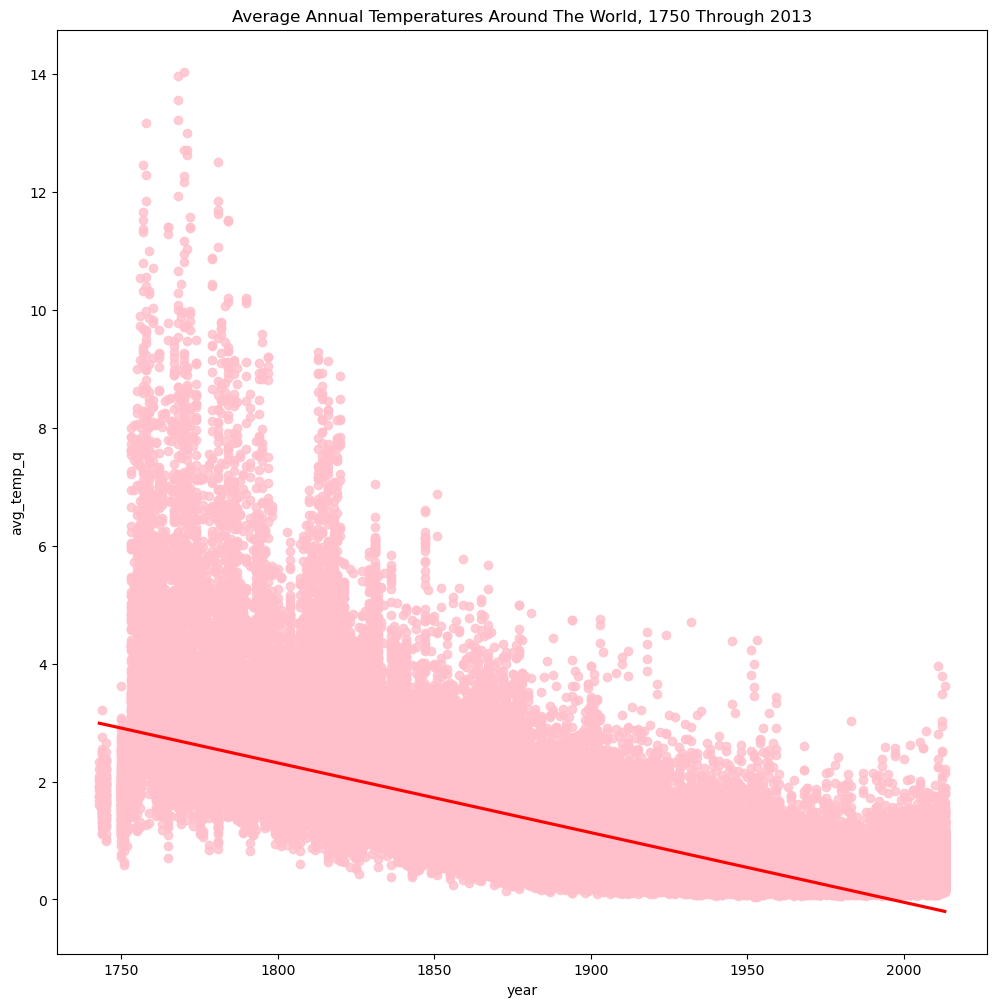

In [11]:
# plotting average temperature uncertainties ('avg_temp_q') against 'year'

plt.figure(figsize = (12, 12))

sns.regplot(data = temp, y = 'avg_temp_q', x = 'year', color = 'pink', 
            line_kws = {'color': 'red'})

plt.title('Average Annual Temperatures Around The World, 1750 Through 2013')

**This plot shows that there has been a decrease in average temperature uncertainty range (upper and lower ranges) since 1750.**

In [12]:
# countries

temp['country'].sort_values().unique()

array(['Afghanistan', 'Angola', 'Australia', 'Bangladesh', 'Brazil',
       'Burma', 'Canada', 'Chile', 'China', 'Colombia',
       'Congo (Democratic Republic Of The)', "Côte D'Ivoire",
       'Dominican Republic', 'Egypt', 'Ethiopia', 'France', 'Germany',
       'India', 'Indonesia', 'Iran', 'Iraq', 'Italy', 'Japan', 'Kenya',
       'Mexico', 'Morocco', 'Nigeria', 'Pakistan', 'Peru', 'Philippines',
       'Russia', 'Saudi Arabia', 'Senegal', 'Singapore', 'Somalia',
       'South Africa', 'South Korea', 'Spain', 'Sudan', 'Syria', 'Taiwan',
       'Tanzania', 'Thailand', 'Turkey', 'Ukraine', 'United Kingdom',
       'United States', 'Vietnam', 'Zimbabwe'], dtype=object)

In [13]:
# cities

temp['city'].sort_values().unique()

array(['Abidjan', 'Addis Abeba', 'Ahmadabad', 'Aleppo', 'Alexandria',
       'Ankara', 'Baghdad', 'Bangalore', 'Bangkok', 'Belo Horizonte',
       'Berlin', 'Bogotá', 'Bombay', 'Brasília', 'Cairo', 'Calcutta',
       'Cali', 'Cape Town', 'Casablanca', 'Changchun', 'Chengdu',
       'Chicago', 'Chongqing', 'Dakar', 'Dalian', 'Dar Es Salaam',
       'Delhi', 'Dhaka', 'Durban', 'Faisalabad', 'Fortaleza', 'Gizeh',
       'Guangzhou', 'Harare', 'Harbin', 'Ho Chi Minh City', 'Hyderabad',
       'Ibadan', 'Istanbul', 'Izmir', 'Jaipur', 'Jakarta', 'Jiddah',
       'Jinan', 'Kabul', 'Kano', 'Kanpur', 'Karachi', 'Kiev', 'Kinshasa',
       'Lagos', 'Lahore', 'Lakhnau', 'Lima', 'London', 'Los Angeles',
       'Luanda', 'Madras', 'Madrid', 'Manila', 'Mashhad', 'Melbourne',
       'Mexico', 'Mogadishu', 'Montreal', 'Moscow', 'Nagoya', 'Nagpur',
       'Nairobi', 'Nanjing', 'New Delhi', 'New York', 'Paris', 'Peking',
       'Pune', 'Rangoon', 'Rio De Janeiro', 'Riyadh', 'Rome',
       'Saint Petersbu

In [14]:
# looking at Turkey

(temp['country'] == 'Turkey').sum()

9239

In [15]:
# assigning 'Turkey' data into new df

tk = temp[temp['country'] == 'Turkey']
tk.sample(3)

avg_temp  avg_temp_q    city country     month  year
date                                                            
1856-04-01     7.969       1.910  Ankara  Turkey     April  1856
2006-05-01    15.446       0.364  Ankara  Turkey       May  2006
1936-11-01    15.046       0.600   Izmir  Turkey  November  1936

In [16]:
# assigning 'Istanbul' data into new df

tk = tk[tk['city'] == 'Istanbul']
tk.tail(3)


avg_temp  avg_temp_q      city country   month  year
date                                                            
2013-06-01    21.853       0.504  Istanbul  Turkey    June  2013
2013-07-01    23.553       0.515  Istanbul  Turkey    July  2013
2013-08-01    24.724       0.485  Istanbul  Turkey  August  2013

In [17]:
# date range

tk.index.min(), tk.index.max()

(Timestamp('1743-11-01 00:00:00'), Timestamp('2013-08-01 00:00:00'))

**The data goes from 01 Nov 1743 to 01 Aug 2013.**

In [18]:
# setting date to 1800 and later

tk = tk[tk['year'] >= 1800]

In [19]:
tk.head()

avg_temp  avg_temp_q      city country     month  year
date                                                              
1800-01-01     5.320       2.294  Istanbul  Turkey   January  1800
1800-02-01     6.053       3.295  Istanbul  Turkey  February  1800
1800-03-01     4.949       2.657  Istanbul  Turkey     March  1800
1800-04-01    14.149       2.052  Istanbul  Turkey     April  1800
1800-05-01    16.493       1.798  Istanbul  Turkey       May  1800

In [20]:
# dropping city, country cols

tk = tk.drop(columns = ['city', 'country'])

## Splitting Into TVT

In [21]:
# splitting data

train_long = int(0.5 * len(tk))

val_test_fen = int(0.7 * len(tk))

train_long, val_test_fen

(1282, 1794)

In [22]:
# splitting data into TVT

train = tk.iloc[:train_long]

val = tk.iloc[train_long:val_test_fen]

test = tk.iloc[val_test_fen:]

train.shape, val.shape, test.shape

((1282, 4), (512, 4), (770, 4))

In [23]:
# look at train

train.sample(3)

avg_temp  avg_temp_q     month  year
date                                            
1878-10-01    16.404       0.836   October  1878
1881-11-01     8.769       0.987  November  1881
1819-10-01    16.303       1.870   October  1819

In [24]:
# date range

train.index.min(), train.index.max()

(Timestamp('1800-01-01 00:00:00'), Timestamp('1906-10-01 00:00:00'))

**The train dataset contains data from 01 Jan 1800 to 01 Oct 1906.**

Text(0.5, 1.0, 'Average Annual & Monthly Temperatures In Istanbul, Turkey, 1800 Through 1906')

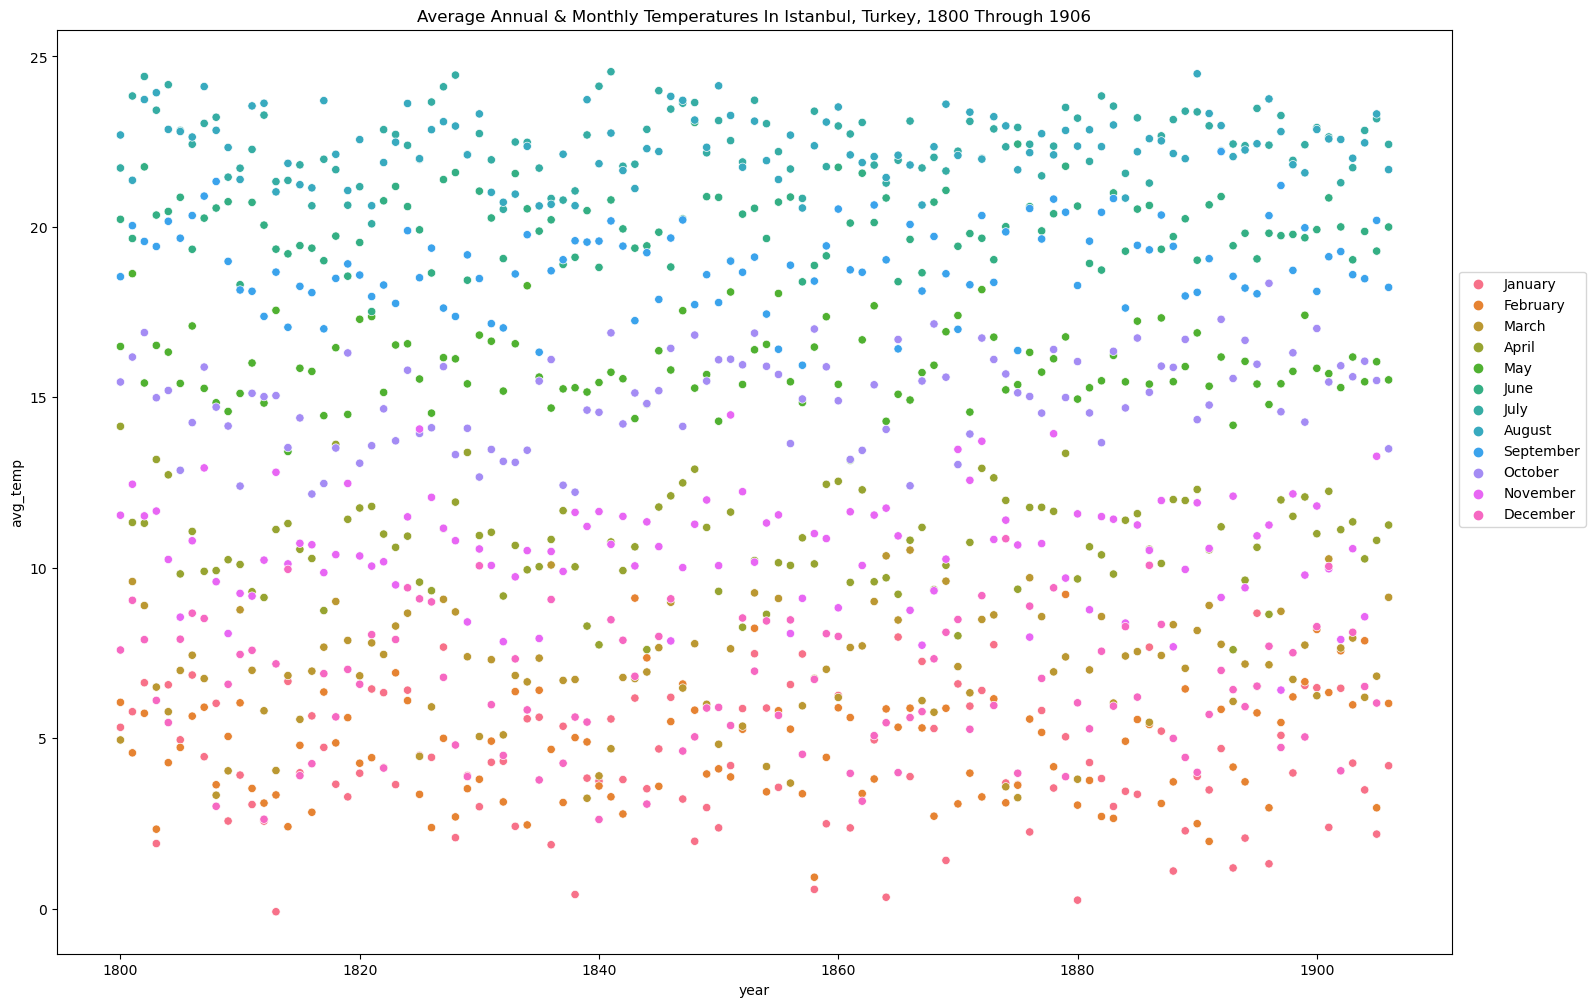

In [25]:
# plotting Average Annual & Monthly Temperatures In Turkey, 1800 Through 1906

plt.figure(figsize = (18, 12))

sns.scatterplot(data = train, y = 'avg_temp', x = 'year', hue = 'month')

plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.6))

plt.title('Average Annual & Monthly Temperatures In Istanbul, Turkey, 1800 Through 1906')

**The above graph demonstrates the consistency in seasonality in temperatures in Istanbul, with relatively little variance over the centuries.**

Text(0.5, 1.0, 'Average Temperature Uncertainty In Istanbul, 1800 Through 1906')

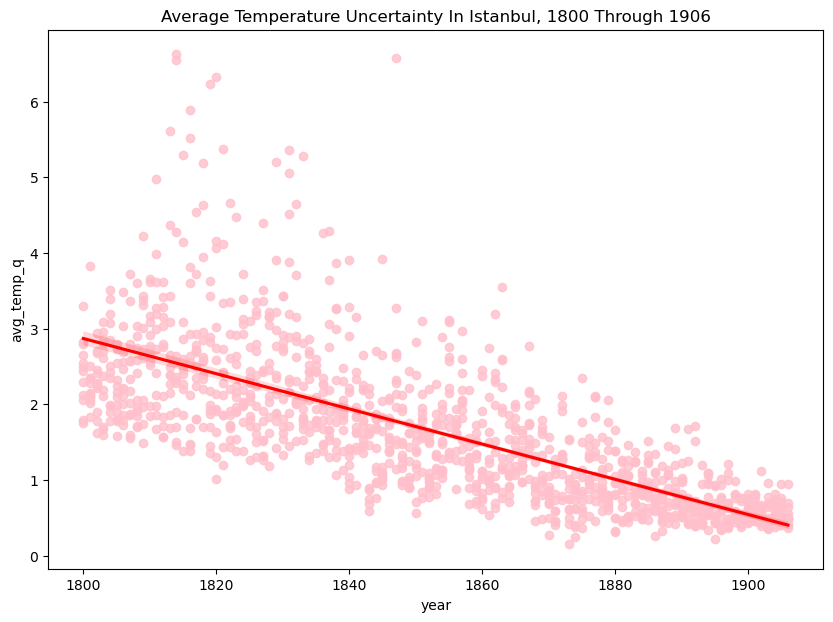

In [26]:
# plotting average temperature uncertainties ('avg_temp_q') against 'avg_temp'

plt.figure(figsize = (10, 7))

sns.regplot(data = train, y = 'avg_temp_q', x = 'year', color = 'pink', 
            line_kws = {'color': 'red'})

plt.title('Average Temperature Uncertainty In Istanbul, 1800 Through 1906')

**The above graph shows that as the years passed, the average temperature uncertainty in Istanbul decreased.**

In [27]:
# highest average temp

train['avg_temp'].idxmax()

Timestamp('1841-07-01 00:00:00')

In [28]:
# lowest average temp

train['avg_temp'].idxmin()

Timestamp('1813-01-01 00:00:00')

Text(0.5, 1.0, 'Average Temperature For 3-Month Periods In Instanbul, 1801 To 1906')

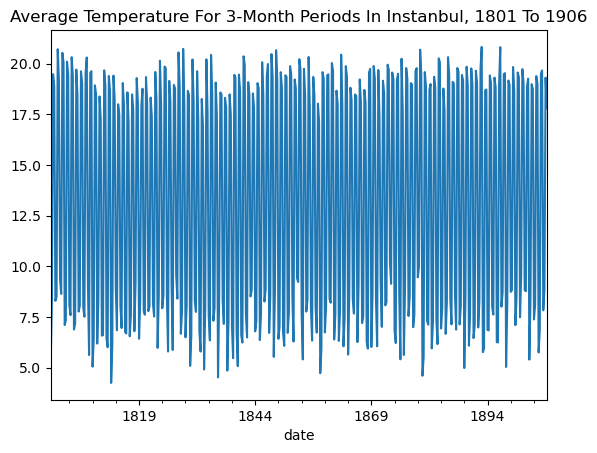

In [29]:
# avg monthly temp 1801 to 1907

train['avg_temp'].resample('3m').mean().plot()

plt.title('Average Temperature For 3-Month Periods In Instanbul, 1801 To 1906')

**The above plot shows the average temperature for 3-month periods in Istanbul, 1801 to 1906. The temperature appears relatively consistent in its highs and lows.**

<AxesSubplot:xlabel='date'>

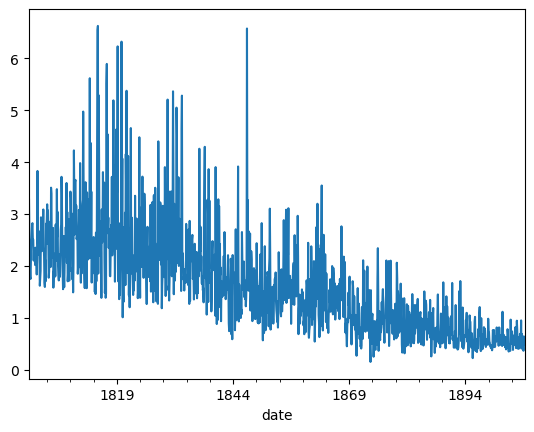

In [30]:
# plotting temperature uncertainty

train['avg_temp_q'].plot()

**The above graph again shows that, as the years passed, the average temperature uncertainty in Istanbul decreased. This is logical, given the growing precision of scientific and observational methods.**  

**Going forward, the 'avg_temp_q' column will be dropped, as it does not come in to play in determining future temperatures in this project.**

In [31]:
# dropping average temperature uncertainty

train = train.drop(columns = 'avg_temp_q')

In [32]:
train.head(1)

avg_temp    month  year
date                               
1800-01-01      5.32  January  1800

## Analyse

## Last-Observed Value

In [33]:
# take the final item of 'avg_temp' in train and assign to variable

last_temp = train['avg_temp'][-1:][0]
print(f'The last-observed value on train is {last_temp}.')

The last-observed value on train is 13.49.


In [34]:
# create baseline (yhat)

yhat_df = pd.DataFrame({'avg_temp' : last_temp}, index = val.index)

yhat_df.sample(3)

avg_temp
date                
1912-05-01     13.49
1939-08-01     13.49
1909-11-01     13.49

In [35]:
# rmse 

rmse = round(sqrt(mean_squared_error(val['avg_temp'], yhat_df['avg_temp'])), 0)
rmse

7.0

In [36]:
# create an empty dataframe

eval_df = pd.DataFrame(columns = ['model_type', 'RMSE'])

eval_df

Empty DataFrame
Columns: [model_type, RMSE]
Index: []

In [37]:

def append_eval_df(model_type, target_var):
    
    # rmse = evaluate(target_var)
    
    f = {'model_type' : [model_type], 'target_var' : [target_var], 'RMSE' : [rmse]}
    
    f = pd.DataFrame(f)
    
    return eval_df.append(f, ignore_index = True)

In [38]:
eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = 'avg_temp')

    # 'last_observed_value' = the yhat of the last-observed value baseline model

eval_df

model_type  RMSE target_var
0  last_observed_value   7.0   avg_temp

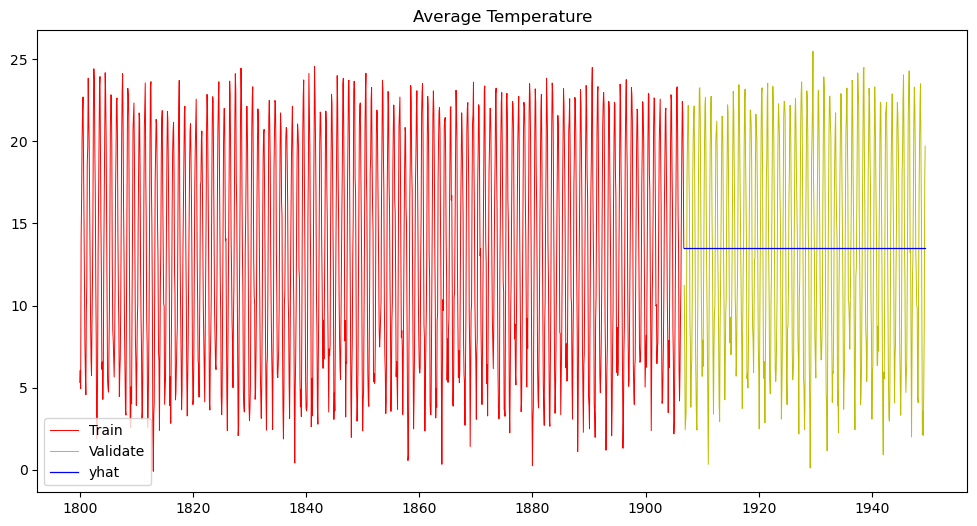

The RMSE on train is 7.0.


In [39]:
# plotting function 

plot_eval(train, val, yhat_df, 'avg_temp')
    
print(f'The RMSE on train is {rmse}.')


**The yhat line for the last-observed value model is relatively in the horizontal centre of the data.**

## Simple Average

In [40]:
# compute simple average of 'avg_temp' (from train data)

avt = round(train['avg_temp'].mean(), 2)

print(f'The simple average is {avt}.')

The simple average is 13.22.


In [41]:
# create yhat_df for simple average

yhat_df = pd.DataFrame({'avg_temp':[avt]}, index = val.index)

In [42]:
yhat_df.head(3)

avg_temp
date                
1906-11-01     13.22
1906-12-01     13.22
1907-01-01     13.22

In [43]:
yhat_df.describe().T

count   mean           std    min    25%    50%    75%    max
avg_temp  512.0  13.22  4.623045e-14  13.22  13.22  13.22  13.22  13.22

In [44]:
# rmse

rmse = round(sqrt(mean_squared_error(val['avg_temp'], yhat_df['avg_temp'])), 0)
rmse

7.0

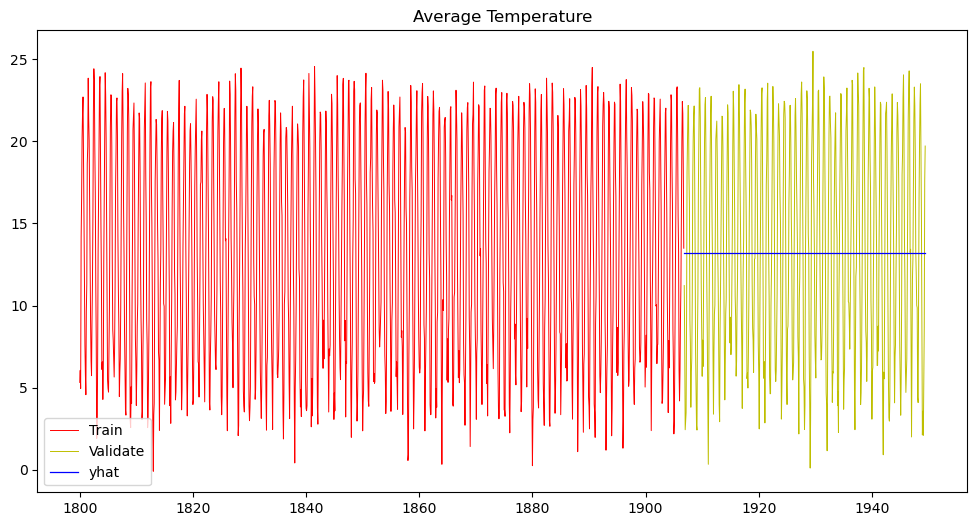

The RMSE on train is 7.0.


In [45]:
# plot for simple average

plot_eval(train, val, yhat_df, 'avg_temp')

print(f'The RMSE on train is {rmse}.')

**The yhat line for the simple average model is relatively in the horizontal centre of the data.**

In [46]:
# append the evaluate-model dataframe

eval_df = append_eval_df('simple_average', 'avg_temp')

##  Moving Average

In [47]:
# set period to 90 days, and obtaining only the final entry

period = 90

train['avg_temp'].rolling(period).mean()[-1]

13.849477777777777

In [48]:
# saving the most recent 60-day moving average 

rolling_avg = round(train['avg_temp'].rolling(period).mean()[-1], 2)
rolling_avg

13.85

In [49]:
# create yhat_df for moving average : baseline

yhat_df = pd.DataFrame({'avg_temp':[rolling_avg]}, index = val.index)

In [50]:
# looking at table

yhat_df.head(2)

avg_temp
date                
1906-11-01     13.85
1906-12-01     13.85

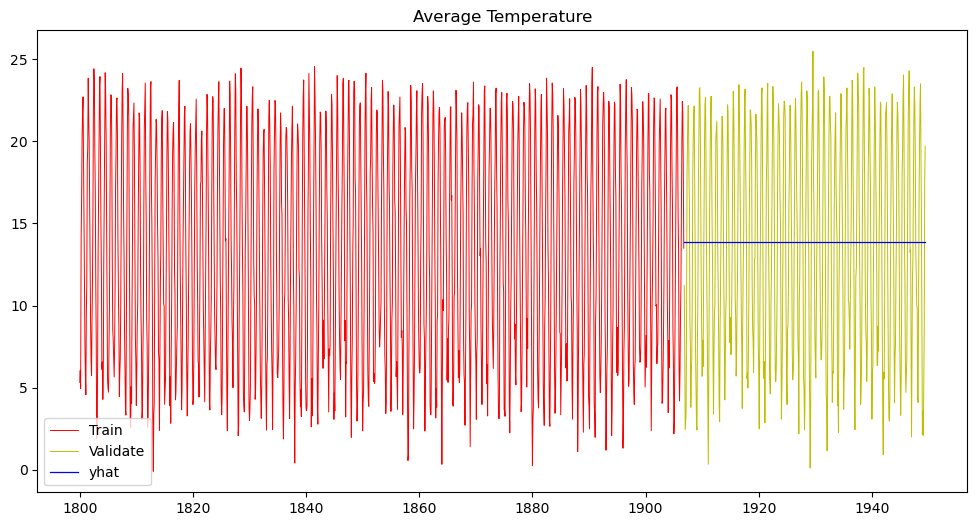

In [51]:
# plotting average temperature for rolling average

plot_eval(train, val, yhat_df, 'avg_temp')

**The yhat line for the moving average model is relatively in the horizontal centre of the data.**

In [52]:
# append the evaluate-model dataframe

eval_df = append_eval_df('moving_average', 'avg_temp')

In [53]:
eval_df

model_type  RMSE target_var
0  last_observed_value   7.0   avg_temp
1       simple_average   7.0   avg_temp
2       moving_average   7.0   avg_temp

**So far, all three models have an identical RMSE.**

## Holt's Linear Model

In [54]:
col = 'avg_temp' 

# create the Holt Object

model = Holt(train[col], exponential = False, damped = True)


In [55]:
# fit the Holt object

model = model.fit(optimized = True)

In [56]:
# creating df wtih Holt's Linear Model predictions

yhat_avg_temp = model.predict(start = val.index[0],
                              end = val.index[-1])

In [57]:
# looking at the data

yhat_avg_temp

1906-11-01    9.955290
1906-12-01    6.985435
1907-01-01    4.609551
1907-02-01    2.708843
1907-03-01    1.188278
                ...   
1949-02-01   -4.893986
1949-03-01   -4.893986
1949-04-01   -4.893986
1949-05-01   -4.893986
1949-06-01   -4.893986
Freq: MS, Length: 512, dtype: float64

In [58]:
# addign avg_temp col to yhat_df

yhat_df['avg_temp'] = round(yhat_avg_temp, 2)

In [59]:
yhat_df.head(3)

avg_temp
date                
1906-11-01      9.96
1906-12-01      6.99
1907-01-01      4.61

In [60]:
# rmse

rmse = round(sqrt(mean_squared_error(val['avg_temp'], yhat_df['avg_temp'])), 0)
rmse

20.0

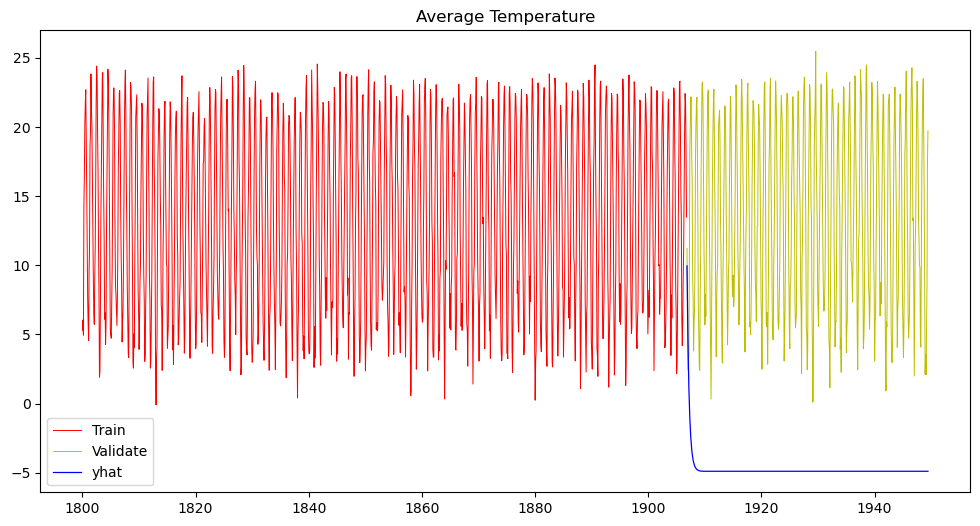

In [61]:
# plotting Holt's Linear Model

plot_eval(train, val, yhat_df, 'avg_temp')

**This is clearly an inappropriate model, as evidenced in the sharp drop to consistently negative temperatures in the yhat.**

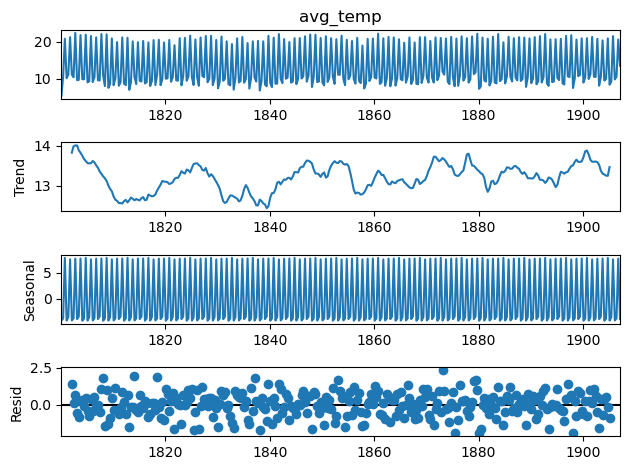

In [62]:
# Seasonal decomposition using moving averages

seasonal = sm.tsa.seasonal_decompose(train['avg_temp'].resample('4m').mean())

seasonal.plot()

None

**The above seasonal decomposition plots show that the temperatures in Istanbul from 1801 to 1907 over 4-month periods remained relatively consistent, with variance within about 2ºC ('Trend').  Comparing the seasonal decomposition models with the Holt's Linear Model shows that there is no basis to confer credibility to the results of the Holt's Linear Model.**

In [63]:
# append the evaluate-model dataframe

eval_df = append_eval_df('Holt_linear', 'avg_temp')

In [64]:
# final table with RMSE values

eval_df

model_type  RMSE target_var
0  last_observed_value   7.0   avg_temp
1       simple_average   7.0   avg_temp
2       moving_average   7.0   avg_temp
3          Holt_linear  20.0   avg_temp

**Overall Modelling Takeaways :**

**The three baseline models — Last-Observed, Simple Average and Moving Average — all had the same RMSE of 7, indicating that the error in predicting temperature was relatively small. This is also seen on the plots, where the yhat is in the relative centre of the data.**

**However, on the Holt's Linear Model, the RMSE was nearly 3 times the RMSE of the other models, coming in at an RMSE of 20. This huge error is also seen in the corresponding graph.**

**Therefore, for this dataset, one of the three baseline models would be preferred. Going forward, the Moving Average will be used on test.**

## Testing On Test



In [65]:
# first entry in test

test.head(1)
# print(test.shape)

avg_temp  avg_temp_q month  year
date                                        
1949-07-01    21.151       0.377  July  1949

In [71]:
# set period to 90 days, and obtaining only the final entry

period = 90

val['avg_temp'].rolling(period).mean()[-1]


13.279466666666668

In [72]:
# saving the most recent 90-day moving average 

rolling_avg_val = round(val['avg_temp'].rolling(period).mean()[-1], 2)
rolling_avg_val

# create yhat_df for moving average on validate : baseline

yhat_test_df = pd.DataFrame({'avg_temp':[rolling_avg_val]}, index = test.index)

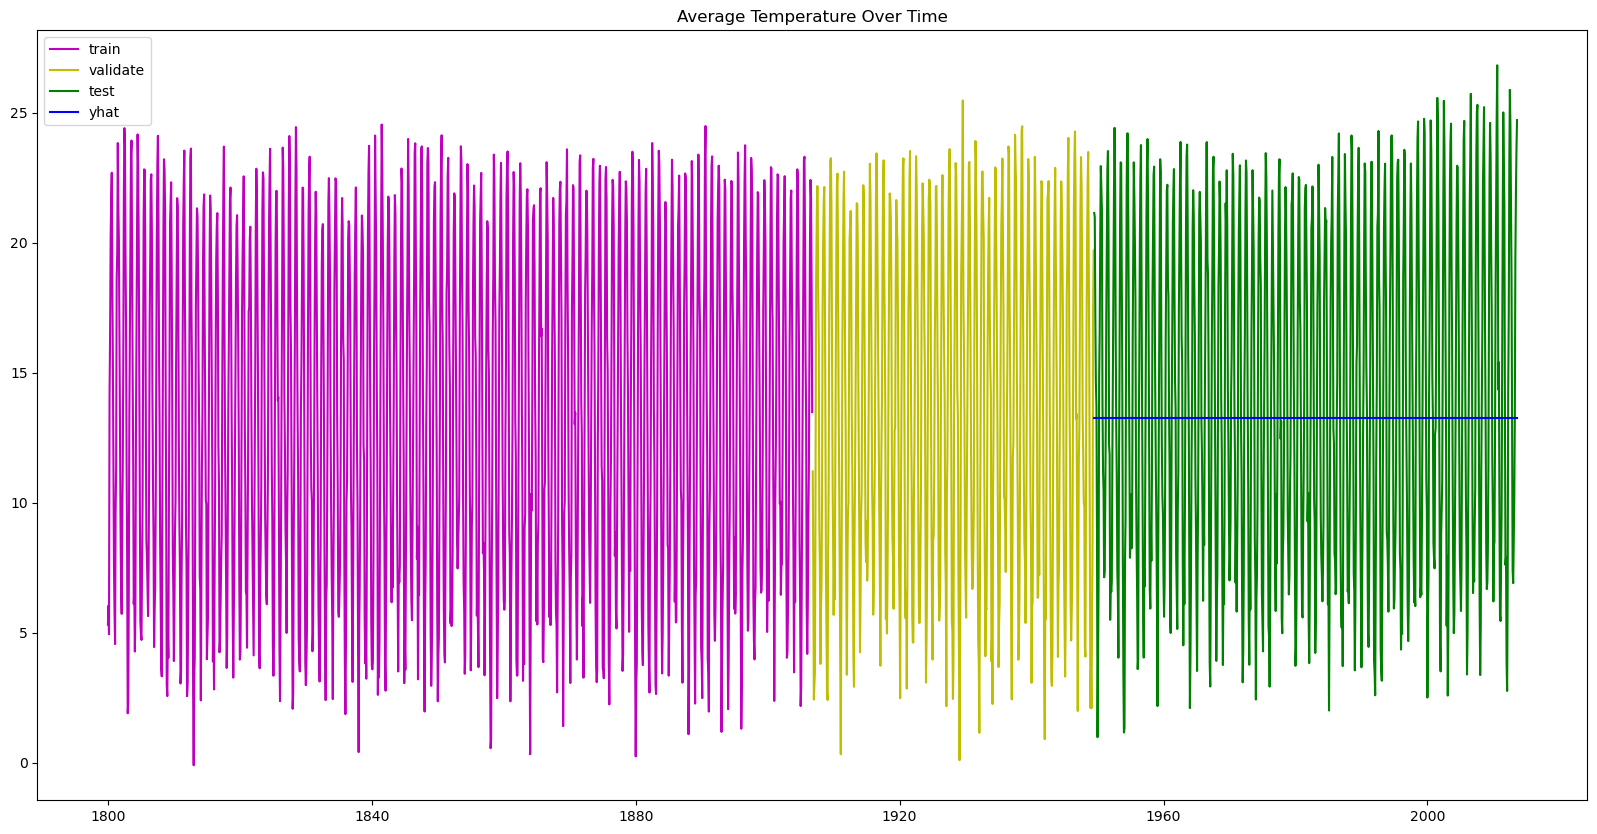

In [73]:
# plotting

plt.figure(figsize = (20, 10))

plt.plot(train['avg_temp'], color = 'm', label = 'train')
plt.plot(val['avg_temp'], color = 'y', label = 'validate')
plt.plot(test['avg_temp'], color = 'g', label = 'test')
plt.plot(yhat_test_df['avg_temp'], color = 'b', label = 'yhat')

plt.legend()
plt.title('Average Temperature Over Time')

plt.show()

**It is clear that the average temperature in Istanbul is and will be consistent throughout time.**

In [86]:
# find the RMSE

rmse_avg_temp = sqrt(mean_squared_error(test['avg_temp'],
                                        yhat_test_df['avg_temp']))

print(f' The RMSE of the average temperature on the test dataset using the Moving Average Model is {round(rmse_avg_temp,0)}.')

 The RMSE of the average temperature on the test dataset using the Moving Average Model is 7.0.


**Final Takeaways :**  
  
**The Moving Average Model again had an RMSE of 7.0, this time on the test dataset. In conclusion, as can be seen in the plot and by the RMSE, this model is relatively accurate in its predictions given the existing consistency of weather in Istanbul, Turkey.**  